In [1]:
import numpy as np
import numpy.linalg as la 
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
# import pymc3 as pm

# plt.rcParams['figure.figsize'] = [16,8]
# plt.rcParams.update({'font.size': 18})
%config InlineBackend.figure_format = 'retina'
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [2]:
dataf = pd.read_csv('premier_league_2013_2014.dat', sep=',', header=None)
dataf.columns = ['goals_home', 'goals_away', 'home_team', 'away_team']

In [3]:
def enforce_corner_constraint(theta, n_teams):
    theta[0] = theta[n_teams] = 0
    return theta

def propose_samples(current, sigma):
    I = np.eye(current.shape[0])
    proposal = np.random.multivariate_normal(current, sigma*I)
    return proposal

def compute_hyper_prior_probabilities(eta):
    tau1 = 1/0.0001
    alpha = beta = 0.1

    mu_attack_logprob = st.norm(0, 1/np.sqrt(tau1)).logpdf(eta[0])
    mu_defense_logprob = st.norm(0, 1/np.sqrt(tau1)).logpdf(eta[1])
    tau_attack_logprob = st.gamma(alpha, scale=1/beta).logpdf(eta[2])
    tau_defense_logprob = st.gamma(alpha, scale=1/beta).logpdf(eta[3])

    eta_logprob = mu_attack_logprob + mu_defense_logprob + tau_attack_logprob + tau_defense_logprob
    return eta_logprob

def compute_prior_probabilities(eta, theta, n_teams):
    tau0 = 1/0.0001

    mu_att = eta[0]
    mu_def = eta[1]
    tau_att = eta[2]
    tau_def = eta[3]
    
    home = theta[-1]
    attack = theta[:n_teams]
    defense = theta[n_teams:-1]

    home_logprob = st.norm(0, 1/np.sqrt(tau0)).logpdf(home)
    attack_logprob = st.norm(mu_att, 1/np.sqrt(tau_att)).logpdf(attack)
    defense_logprob = st.norm(mu_def, 1/np.sqrt(tau_def)).logpdf(defense)

    theta_prob = home_logprob + np.sum(attack_logprob + defense_logprob)
    return theta_prob

def compute_likelihood(theta, n_teams, dataf):

    goals_home = dataf['goals_home'].values.astype(int)
    goals_away = dataf['goals_away'].values.astype(int)
    home_team = dataf['home_team'].values.astype(int)
    away_team = dataf['away_team'].values.astype(int)

    home = theta[-1]
    attack = theta[:n_teams]
    defense = theta[n_teams:-1]

    theta_home = np.exp(home + attack[home_team] - defense[away_team])
    theta_away = np.exp(attack[away_team] - defense[home_team])
    
    loglikelihood_home = st.poisson(theta_home).logpmf(goals_home)
    loglikelihood_away = st.poisson(theta_away).logpmf(goals_away)

    loglikelihood = np.sum(loglikelihood_home + loglikelihood_away)
    return loglikelihood

def compute_probabilities(eta, theta, n_teams, dataf):
    eta_logprob = compute_hyper_prior_probabilities(eta)
    theta_logprob = compute_prior_probabilities(eta, theta, n_teams)
    loglikelihood = compute_likelihood(theta, n_teams, dataf)
    logprob = eta_logprob + theta_logprob + loglikelihood
    return logprob

def metropolis_hastings(n_its, sigma, dataf, thinning, burn_in):

    n_teams = 20
    starting_point = 0.1
    eta_current = np.full(4, starting_point)
    theta_current = enforce_corner_constraint(np.full(1+n_teams*2, starting_point), n_teams)
    samples = []
    rejection = []
    
    for t in range(n_its):

        eta_proposal = propose_samples(eta_current, sigma)
        theta_proposal = enforce_corner_constraint(propose_samples(theta_current, sigma), n_teams)

        current_logprob = compute_probabilities(eta_current, theta_current, n_teams, dataf)
        proposal_logprob = compute_probabilities(eta_proposal, theta_proposal, n_teams, dataf)
        acceptance_logprob = proposal_logprob - current_logprob

        u = np.random.uniform()
        if np.log(u) < acceptance_logprob:
            eta_current = eta_proposal
            theta_current = theta_proposal
            rejection.append(0)
        else:
            rejection.append(1)
        
        if (t % thinning == 0) and (t > burn_in):
            # samples.append([eta_current.copy(), theta_current.copy()])
            samples.append(theta_current[-1].copy())
        
        print(f'Iteration {t+1}/{n_its}', end='\r') if (t+1) % 10 == 0 else None

    return samples, rejection

In [4]:
n_its = 10000
sigmas = [0.005, 0.05, 0.5]
thinning = [1, 5, 20, 50]
burn_in = 0
home_batches = []
rejection_batches = []

for i in range(len(sigmas)):
    for j in range(len(thinning)):

        print(f'Running sigma={sigmas[i]} and thinning={thinning[j]}')
        samples, rejection = metropolis_hastings(n_its, sigmas[i], dataf, thinning[j], burn_in)
        
        np.save(f'samples/home_sigma={sigmas[i]}_thinning={thinning[j]}.npy', samples)
        np.save(f'samples/rejection_sigma={sigmas[i]}_thinning={thinning[j]}.npy', rejection)
        home_batches.append(samples)
        rejection_batches.append(rejection)

Running sigma=0.005 and thinning=1


C:\Users\erikn\AppData\Local\Temp\ipykernel_1160\768197780.py:35: RuntimeWarning: invalid value encountered in sqrt
  attack_logprob = st.norm(mu_att, 1/np.sqrt(tau_att)).logpdf(attack)


C:\Users\erikn\AppData\Local\Temp\ipykernel_1160\768197780.py:36: RuntimeWarning: invalid value encountered in sqrt
  defense_logprob = st.norm(mu_def, 1/np.sqrt(tau_def)).logpdf(defense)


Running sigma=0.005 and thinning=5
Running sigma=0.005 and thinning=20
Running sigma=0.005 and thinning=50
Running sigma=0.05 and thinning=1
Running sigma=0.05 and thinning=5
Running sigma=0.05 and thinning=20
Running sigma=0.05 and thinning=50
Running sigma=0.5 and thinning=1
Running sigma=0.5 and thinning=5
Running sigma=0.5 and thinning=20
Running sigma=0.5 and thinning=50


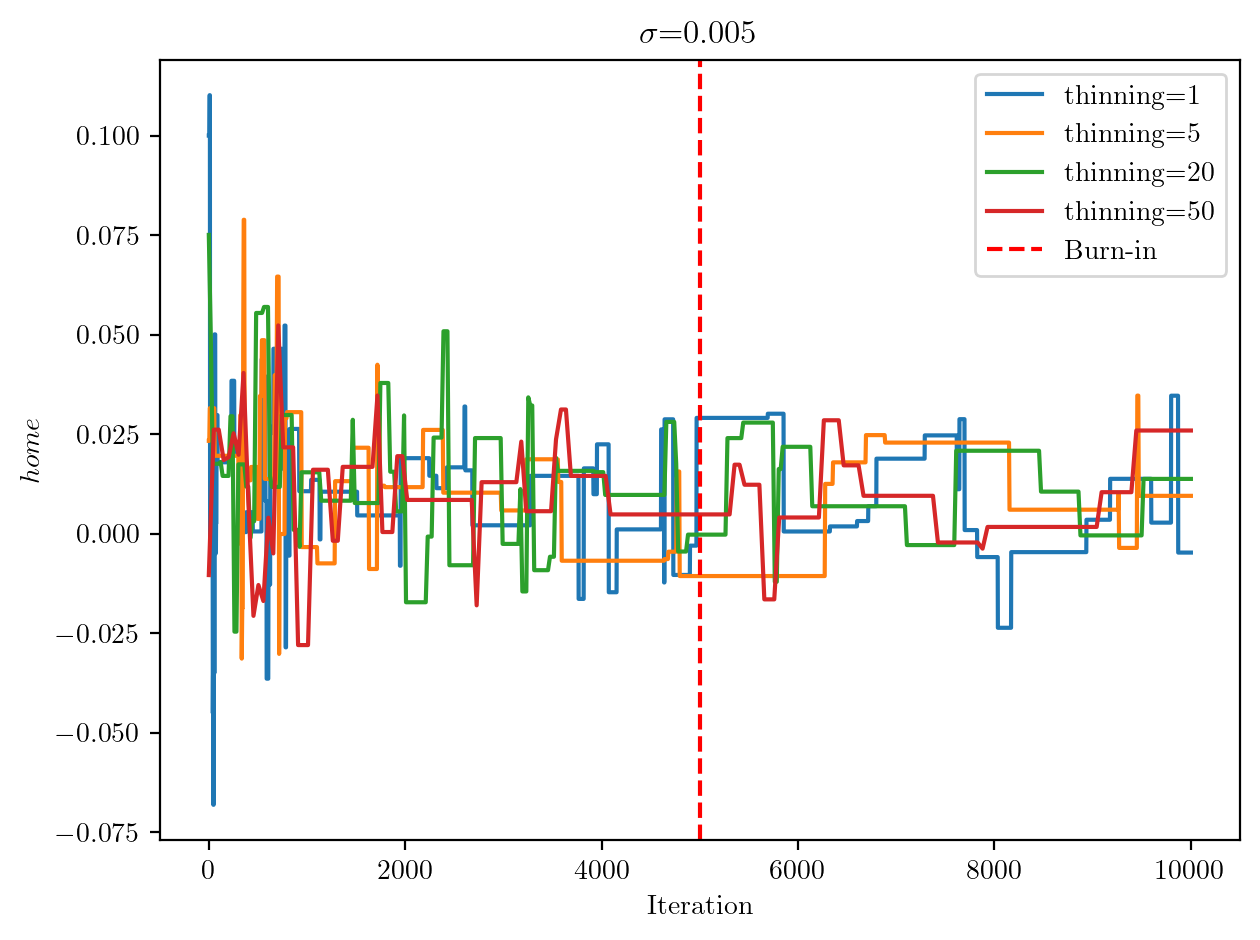

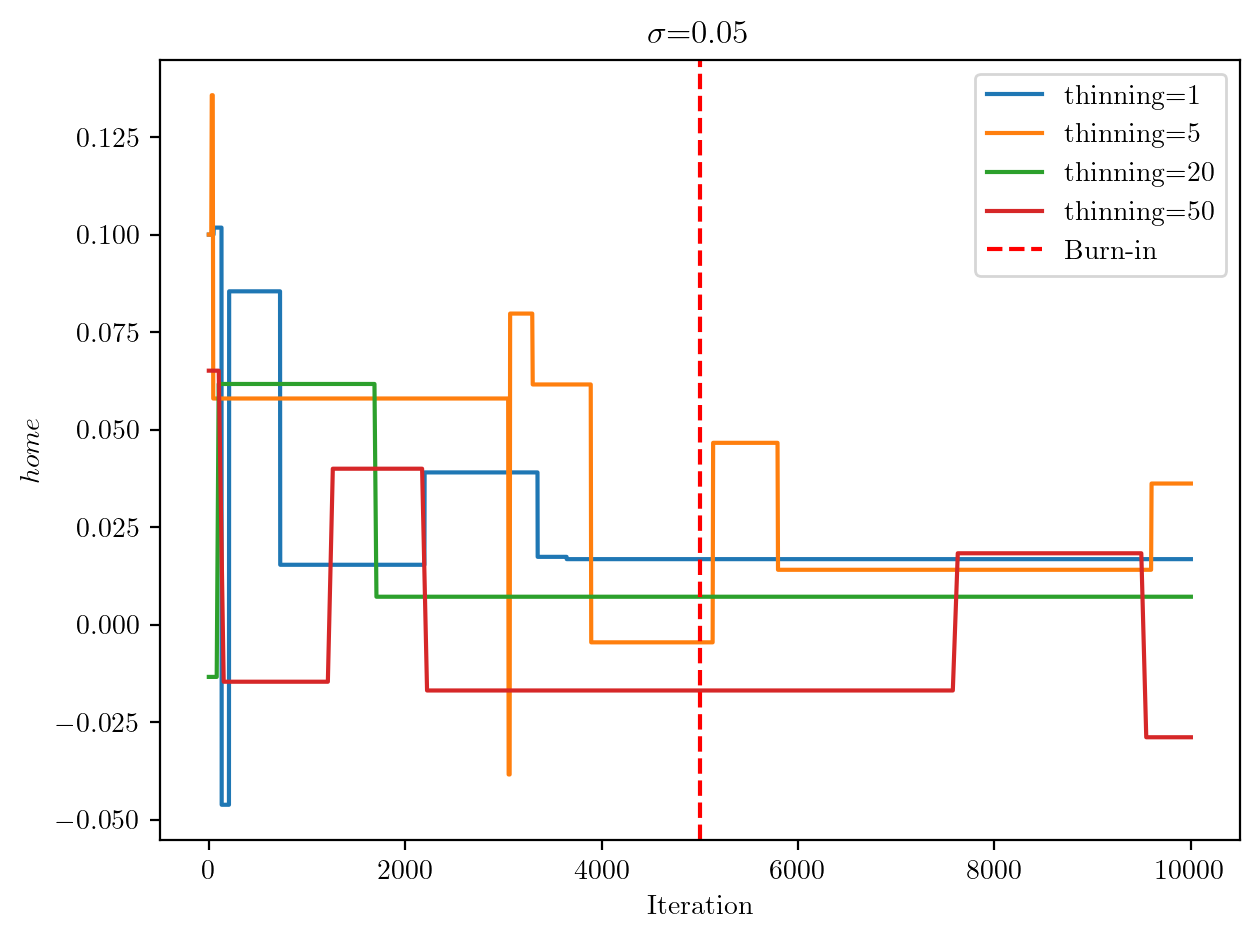

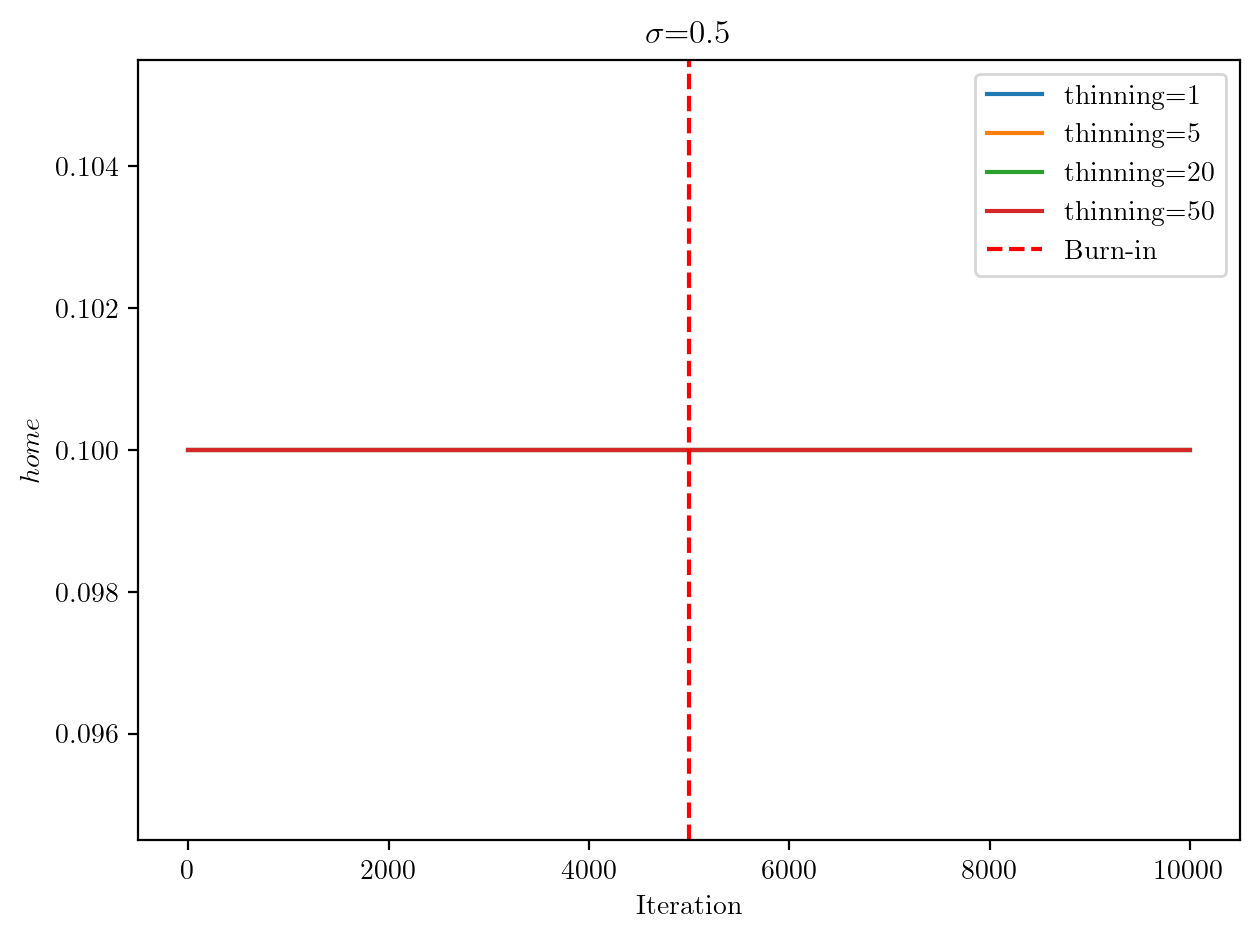

In [46]:
for j in range(len(sigmas)):
    home = [np.load(f'samples/home_sigma={sigmas[j]}_thinning={thinning[i]}.npy') for i in range(len(thinning))]
    fig = plt.figure()
    ax = plt.axes()
    [ax.plot(np.array(np.linspace(0,10000,home[i].shape[0])), home[i], '-', label=f'thinning={thinning[i]}') for i in range(len(thinning))]
    ax.axvline(x=5000, color='red', linestyle='--', label='Burn-in')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('$home$')
    ax.set_title(f'$\sigma$={sigmas[j]}')
    ax.legend()
    fig.tight_layout()
    fig.savefig(f'report-images/home_sigma={sigmas[j]}.png', dpi=300)
    plt.show()

In [61]:
for i in range(len(sigmas)):
    for j in range(len(thinning)):
        rejection = np.load(f'samples/rejection_sigma={sigmas[i]}_thinning={thinning[j]}.npy')
        rejection = rejection[5000:]
        print(f'Rejection rate: sigma={sigmas[i]}, thinning={thinning[j]}:', np.mean(rejection))

Rejection rate: sigma=0.005, thinning=1: 0.9964
Rejection rate: sigma=0.005, thinning=5: 0.9982
Rejection rate: sigma=0.005, thinning=20: 0.9978
Rejection rate: sigma=0.005, thinning=50: 0.9976
Rejection rate: sigma=0.05, thinning=1: 1.0
Rejection rate: sigma=0.05, thinning=5: 0.9994
Rejection rate: sigma=0.05, thinning=20: 1.0
Rejection rate: sigma=0.05, thinning=50: 0.9996
Rejection rate: sigma=0.5, thinning=1: 1.0
Rejection rate: sigma=0.5, thinning=5: 1.0
Rejection rate: sigma=0.5, thinning=20: 1.0
Rejection rate: sigma=0.5, thinning=50: 1.0


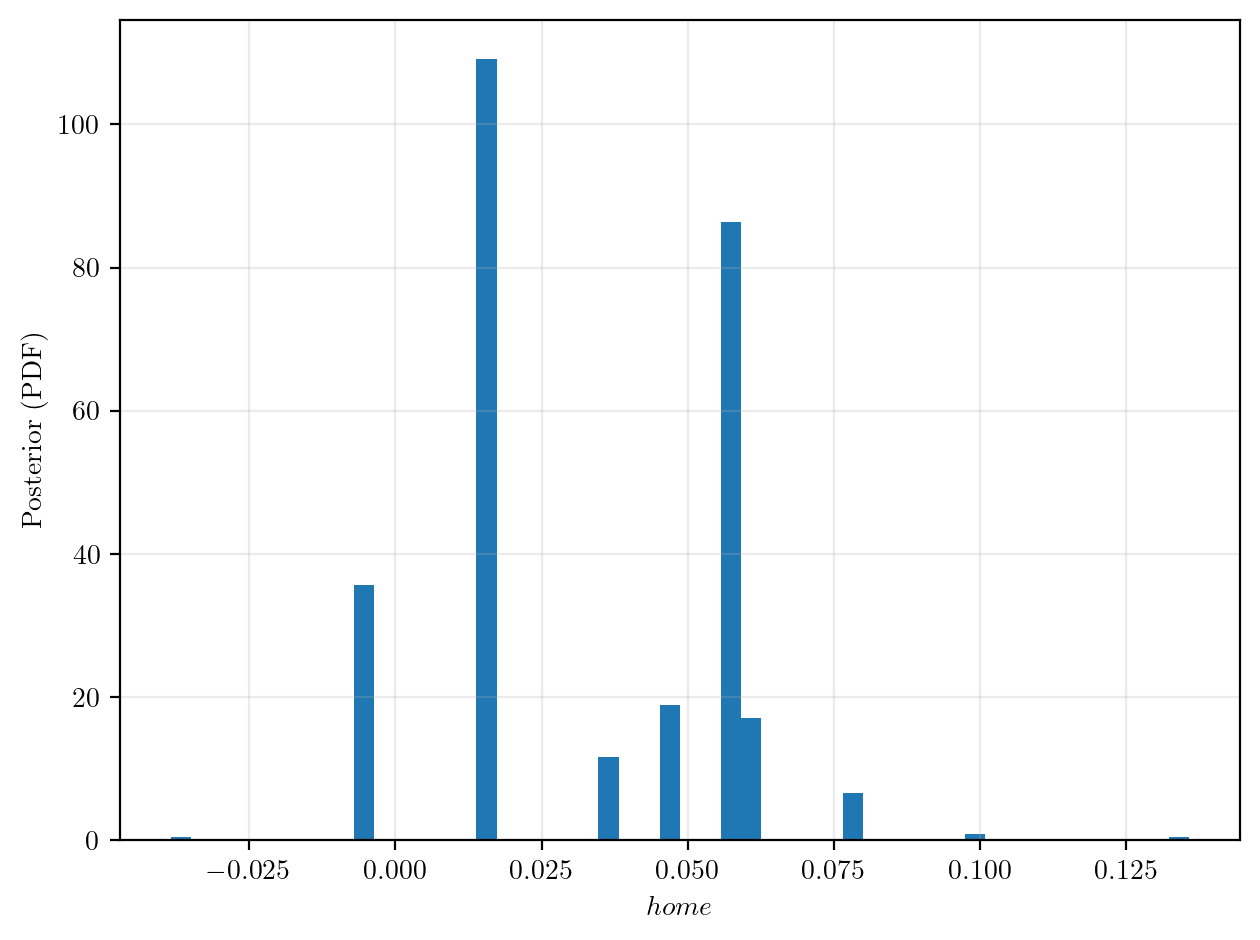

In [78]:
home = np.load(f'samples/home_sigma={sigmas[1]}_thinning={thinning[1]}.npy')
fig = plt.figure()
plt.hist(home, bins=50, density=True)
plt.xlabel('$home$')
plt.ylabel('Posterior (PDF)')
plt.grid(True, alpha=0.25)
fig.tight_layout()
fig.savefig(f'report-images/home_hist.png', dpi=300)
plt.show()

In [ ]:
expected_attack = np.mean(home_batches[1])
expected_defense = np.mean(home_batches[1])

fig = plt.figure()
ax = plt.axes()
ax.plot(expected_defense, expected_attack)
for i in range(expected_defense.shape[0]):
    ax.text(expected_defense[i], expected_attack[i], str(i))
ax.set_xlabel('$E[def_i]$')
ax.set_ylabel('$E[att_i]$')
ax.legend()
fig.tight_layout()
fig.savefig(f'report-images/attack_vs_defense.png', dpi=300)

In [153]:

goals_home = dataf['goals_home'].values.astype(int)
goals_away = dataf['goals_away'].values.astype(int)
home_team = dataf['home_team'].values.astype(int)
away_team = dataf['away_team'].values.astype(int)

n_teams = 20
n_games = 380

tau0 = 1/0.0001
tau1 = 1/0.0001
alpha = beta = 1

with pm.Model() as model:

    mu_attack = np.random.normal(0, 1/np.sqrt(tau1)) 
    mu_defense = np.random.normal(0, 1/np.sqrt(tau1)) 
    tau_attack = np.random.gamma(alpha, scale=1/beta)
    tau_defense = np.random.gamma(alpha, scale=1/beta)

    home = np.random.normal(0, 1/np.sqrt(tau0))
    attack = np.random.normal(mu_attack, 1/np.sqrt(tau_attack), n_teams)
    defense = np.random.normal(mu_defense, 1/np.sqrt(tau_defense), n_teams)

    attack[0] = 0
    defense[0] = 0

    theta_home = np.exp(home + attack[home_team] + defense[away_team])
    theta_away = np.exp(attack[away_team] + defense[home_team])

    goals_home = pm.Poisson('goals_home', mu=theta_home, observed=dataf['goals_home'])
    goals_away = pm.Poisson('goals_away', mu=theta_away, observed=dataf['goals_away'])

    step= pm.Metropolis()
    trace = pm.sample(5000, tune=2)

# pm.summary(trace).round(2)

-0.005243385219353964 [ 0.         -0.75849411 -0.85642932 -0.80764781  1.09102823  1.29075864
  0.17124266 -1.9640422  -0.53973761  0.01152908  0.54075601  0.92520672
 -0.70869056 -1.13671518  2.03461706  0.89841708 -1.80771403  1.24050144
  0.41482507 -0.92019833] [ 0.          1.23494069 -1.17355898  0.05939155 -0.13579672 -0.1389449
  1.62013392  0.2833345   1.9685285  -1.02039368 -2.37380617  0.73558595
 -0.32529415  0.89742496 -0.18879405  0.83745047  0.03142729 -1.01406658
  0.43336166 -0.4122914 ]


ValueError: No free random variables to sample.